# Logistic Regression with L2 regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.
 
# Fire up GraphLab Create
 
Make sure you have the latest version of GraphLab Create. Upgrade by

```
   pip install graphlab-create --upgrade
```
See [this page](https://dato.com/download/) for detailed instructions on upgrading.

In [1]:
from __future__ import division
import graphlab

## Load and process review dataset

For this assignment, we will use the same subset of the Amazon product review dataset that we used in Module 3 assignment. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews.

In [2]:
products = graphlab.SFrame('amazon_baby_subset.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to jd62@uw.edu and will expire on April 26, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1502546120.log


Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Compute word counts (only for the **important_words**)

Refer to Module 3 assignment for more details.

In [3]:
# The same feature processing (same as the previous assignments)
# ---------------------------------------------------------------
import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]


def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

# Remove punctuation.
products['review_clean'] = products['review'].apply(remove_punctuation)

# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

Now, let us take a look at what the dataset looks like (**Note:** This may take a few minutes).

In [4]:
products

name,review,rating,sentiment,review_clean,baby
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,1,All of my kids have criednonstop when I tried to ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,We wanted to getsomething to keep track ...,5.0,1,We wanted to getsomething to keep track ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,My daughter had her 1stbaby over a year ago. ...,5.0,1,My daughter had her 1stbaby over a year ago She ...,1
"Lamaze Peekaboo, I LoveYou ...","One of baby's first andfavorite books, and i ...",4.0,1,One of babys first andfavorite books and it is ...,0
SoftPlay Peek-A-BooWhere's Elmo A Childr ...,Very cute interactivebook! My son loves this ...,5.0,1,Very cute interactivebook My son loves this ...,0
Our Baby Girl Memory Book,"Beautiful book, I love itto record cherished t ...",5.0,1,Beautiful book I love itto record cherished t ...,0
Hunnt&reg; FallingFlowers and Birds Kids ...,"Try this out for a springproject !Easy ,fun and ...",5.0,1,Try this out for a springproject Easy fun and ...,0
Blessed By Pope BenedictXVI Divine Mercy Full ...,very nice Divine MercyPendant of Jesus now on ...,5.0,1,very nice Divine MercyPendant of Jesus now on ...,0
Cloth Diaper PinsStainless Steel ...,We bought the pins as my6 year old Autistic son ...,4.0,1,We bought the pins as my6 year old Autistic son ...,0
Cloth Diaper PinsStainless Steel ...,It has been many yearssince we needed diaper ...,5.0,1,It has been many yearssince we needed diaper ...,0


## Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use `seed=2` so that everyone gets the same result.

**Note:** In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters**. Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on a validation set, while evaluation of selected model should always be on a test set.

In [5]:
train_data, validation_data = products.random_split(.8, seed=2)

print 'Training set   : %d data points' % len(train_data)
print 'Validation set : %d data points' % len(validation_data)

Training set   : 42361 data points
Validation set : 10711 data points


## Convert SFrame to NumPy array

Just like in the second assignment of the previous module, we provide you with a function that extracts columns from an SFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels. 

**Note:** The feature matrix includes an additional column 'intercept' filled with 1's to take account of the intercept term.

In [6]:
import numpy as np

def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

We convert both the training and validation sets into NumPy arrays.

**Warning**: This may take a few minutes.

In [7]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

**Are you running this notebook on an Amazon EC2 t2.micro instance?** (If you are using your own machine, please skip this section)

It has been reported that t2.micro instances do not provide sufficient power to complete the conversion in acceptable amount of time. For interest of time, please refrain from running `get_numpy_data` function. Instead, download the [binary file](https://s3.amazonaws.com/static.dato.com/files/coursera/course-3/numpy-arrays/module-4-assignment-numpy-arrays.npz) containing the four NumPy arrays you'll need for the assignment. To load the arrays, run the following commands:
```
arrays = np.load('module-4-assignment-numpy-arrays.npz')
feature_matrix_train, sentiment_train = arrays['feature_matrix_train'], arrays['sentiment_train']
feature_matrix_valid, sentiment_valid = arrays['feature_matrix_valid'], arrays['sentiment_valid']
```

## Building on logistic regression with no L2 penalty assignment

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

We will use the **same code** as in this past assignment to make probability predictions since this part is not affected by the L2 penalty.  (Only the way in which the coefficients are learned is affected by the addition of a regularization term.)

In [8]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    ## YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    ## YOUR CODE HERE
    predictions = 1 / (1 + np.e ** (-score)) 
    
    return predictions

# Adding  L2 penalty

Let us now work on extending logistic regression with L2 regularization. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

** Adding L2 penalty to the derivative** 

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* Recall from the lecture that the link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Note**: As we did in the Regression course, we do not apply the L2 penalty on the intercept. A large intercept does not necessarily indicate overfitting because the intercept is not associated with any particular feature.

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [9]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(errors, feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative -= 2 * l2_penalty * coefficient
        
    return derivative

** Quiz Question:** In the code above, was the intercept term regularized?

To verify the correctness of the gradient ascent algorithm, we provide a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [10]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

** Quiz Question:** Does the term with L2 regularization increase or decrease $\ell\ell(\mathbf{w})$?

The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.  Fill in the code below to complete this modification.

In [13]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] += step_size * derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [14]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

In [45]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39508175
iteration   1: log likelihood of observed labels = -29003.73417180
iteration   2: log likelihood of observed labels = -28834.71441858
iteration   3: log likelihood of observed labels = -28671.80345068
iteration   4: log likelihood of observed labels = -28514.58077957
iteration   5: log likelihood of observed labels = -28362.69830317
iteration   6: log likelihood of observed labels = -28215.85663259
iteration   7: log likelihood of observed labels = -28073.79071393
iteration   8: log likelihood of observed labels = -27936.26093762
iteration   9: log likelihood of observed labels = -27803.04751805
iteration  10: log likelihood of observed labels = -27673.94684207
iteration  11: log likelihood of observed labels = -27548.76901327
iteration  12: log likelihood of observed labels = -27427.33612958
iteration  13: log likelihood of observed labels = -27309.48101569
iteration  14: log likelihood of observed labels = -27195.0462

In [16]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.40062984
iteration   1: log likelihood of observed labels = -29003.76654163
iteration   2: log likelihood of observed labels = -28834.79322654
iteration   3: log likelihood of observed labels = -28671.94687528
iteration   4: log likelihood of observed labels = -28514.80571589
iteration   5: log likelihood of observed labels = -28363.02048079
iteration   6: log likelihood of observed labels = -28216.29071186
iteration   7: log likelihood of observed labels = -28074.35036891
iteration   8: log likelihood of observed labels = -27936.95892966
iteration   9: log likelihood of observed labels = -27803.89576265
iteration  10: log likelihood of observed labels = -27674.95647005
iteration  11: log likelihood of observed labels = -27549.95042714
iteration  12: log likelihood of observed labels = -27428.69905549
iteration  13: log likelihood of observed labels = -27311.03455140
iteration  14: log likelihood of observed labels = -27196.7989

In [17]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.48385120
iteration   1: log likelihood of observed labels = -29004.25177457
iteration   2: log likelihood of observed labels = -28835.97382190
iteration   3: log likelihood of observed labels = -28674.09410083
iteration   4: log likelihood of observed labels = -28518.17112932
iteration   5: log likelihood of observed labels = -28367.83774654
iteration   6: log likelihood of observed labels = -28222.77708939
iteration   7: log likelihood of observed labels = -28082.70799392
iteration   8: log likelihood of observed labels = -27947.37595368
iteration   9: log likelihood of observed labels = -27816.54738615
iteration  10: log likelihood of observed labels = -27690.00588850
iteration  11: log likelihood of observed labels = -27567.54970126
iteration  12: log likelihood of observed labels = -27448.98991327
iteration  13: log likelihood of observed labels = -27334.14912742
iteration  14: log likelihood of observed labels = -27222.8604

In [18]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29180.31606471
iteration   1: log likelihood of observed labels = -29009.07176112
iteration   2: log likelihood of observed labels = -28847.62378912
iteration   3: log likelihood of observed labels = -28695.14439397
iteration   4: log likelihood of observed labels = -28550.95060743
iteration   5: log likelihood of observed labels = -28414.45771129
iteration   6: log likelihood of observed labels = -28285.15124375
iteration   7: log likelihood of observed labels = -28162.56976044
iteration   8: log likelihood of observed labels = -28046.29387744
iteration   9: log likelihood of observed labels = -27935.93902900
iteration  10: log likelihood of observed labels = -27831.15045502
iteration  11: log likelihood of observed labels = -27731.59955260
iteration  12: log likelihood of observed labels = -27636.98108219
iteration  13: log likelihood of observed labels = -27547.01092670
iteration  14: log likelihood of observed labels = -27461.4242

In [19]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29271.85955115
iteration   1: log likelihood of observed labels = -29271.71006589
iteration   2: log likelihood of observed labels = -29271.65738833
iteration   3: log likelihood of observed labels = -29271.61189923
iteration   4: log likelihood of observed labels = -29271.57079975
iteration   5: log likelihood of observed labels = -29271.53358505
iteration   6: log likelihood of observed labels = -29271.49988440
iteration   7: log likelihood of observed labels = -29271.46936584
iteration   8: log likelihood of observed labels = -29271.44172890
iteration   9: log likelihood of observed labels = -29271.41670149
iteration  10: log likelihood of observed labels = -29271.39403722
iteration  11: log likelihood of observed labels = -29271.37351294
iteration  12: log likelihood of observed labels = -29271.35492661
iteration  13: log likelihood of observed labels = -29271.33809523
iteration  14: log likelihood of observed labels = -29271.3228

## Compare coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

In [46]:
table = graphlab.SFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

Now, let's run the function `add_coefficients_to_table` for each of the L2 penalty strengths.

In [47]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2]
(intercept),-0.0637421352275,-0.0631430877074,-0.06225594377,-0.0504383651953
baby,0.0740730059216,0.0739938541405,0.0738773534804,0.0723603602218
one,0.0127525057784,0.0124949704481,0.0121152529534,0.0072472833187
great,0.801624989778,0.796896933003,0.789935147221,0.701425073675
love,1.05855398207,1.05085568099,1.03952851585,0.896644133101
use,-0.000104152191248,0.000162857656177,0.000555710975756,0.00548103267946
would,-0.287021443534,-0.286027202975,-0.284564035562,-0.265992746226
like,-0.00338447399293,-0.00344208577045,-0.00352729444966,-0.00463499283253
easy,0.984558819873,0.977600149782,0.967361836631,0.838244832955
little,0.524419456364,0.521384726107,0.516917392491,0.460234577902


Using **the coefficients trained with L2 penalty 0**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.

**Quiz Question**. Which of the following is **not** listed in either **positive_words** or **negative_words**?

In [81]:
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(table['word'], table['coefficients [L2=0]'])]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)
positive_words = [x for (x, y) in word_coefficient_tuples[0:10]]



In [85]:
word_coefficient_tuples[0:10]

[('love', 1.0585539820695435),
 ('loves', 1.0524840477983537),
 ('easy', 0.9845588198731925),
 ('perfect', 0.8356932076383464),
 ('great', 0.8016249897781763),
 ('happy', 0.5573952023634463),
 ('best', 0.535033889771777),
 ('little', 0.5244194563643345),
 ('fits', 0.4876522532652972),
 ('well', 0.45386648676755054)]

In [88]:
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=False)
word_coefficient_tuples[0:10]
negative_words = [x for (x, y) in word_coefficient_tuples[0:10]]

In [67]:
positive_words

['love',
 'loves',
 'easy',
 'perfect',
 'great',
 'happy',
 'best',
 'little',
 'fits',
 'well']

In [89]:
negative_words

['disappointed',
 'money',
 'return',
 'waste',
 'returned',
 'broke',
 'work',
 'thought',
 'idea',
 'cheap']

Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table.filter_by(column_name='word', values=positive_words)
    table_negative_words = table.filter_by(column_name='word', values=negative_words)
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in xrange(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in xrange(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

Run the following cell to generate the plot. Use the plot to answer the following quiz question.

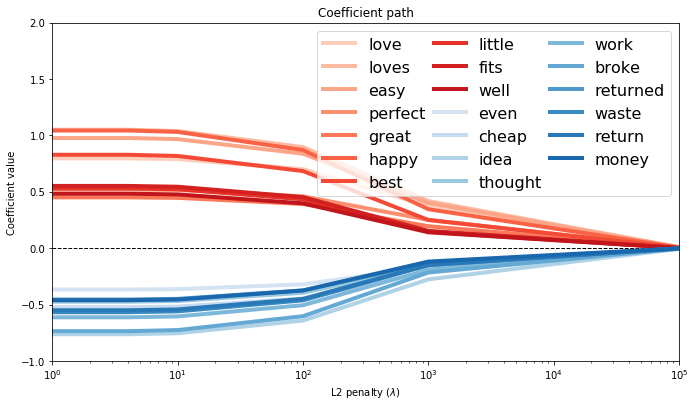

In [70]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

**Quiz Question**: (True/False) All coefficients consistently get smaller in size as the L2 penalty is increased.

**Quiz Question**: (True/False) The relative order of coefficients is preserved as the L2 penalty is increased. (For example, if the coefficient for 'cat' was more positive than that for 'dog', this remains true as the L2 penalty increases.)

## Measuring accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. The only thing that changes is the estimated coefficients used in this prediction.

Based on the above, we will use the same code that was used in Module 3 assignment.

In [71]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

Below, we compare the accuracy on the **training data** and **validation data** for all the models that were trained in this assignment.  We first calculate the accuracy values and then build a simple report summarizing the performance for the various models.

In [72]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [73]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print "L2 penalty = %g" % key
    print "train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key])
    print "--------------------------------------------------------------------------------"

L2 penalty = 0
train accuracy = 0.785156157787, validation_accuracy = 0.78143964149
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.785108944548, validation_accuracy = 0.781533003454
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.784990911452, validation_accuracy = 0.781719727383
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.783975826822, validation_accuracy = 0.781066193633
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.775855149784, validation_accuracy = 0.771356549342
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.680366374731, validation_accuracy = 0.667818130893
---------------------------------------------------------------------------

<function matplotlib.pyplot.tight_layout>

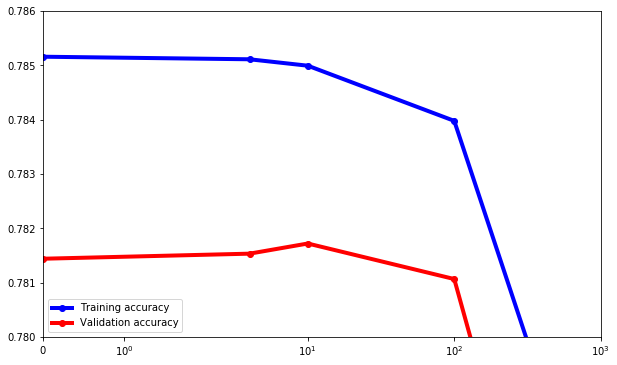

In [74]:
# Optional. Plot accuracy on training and validation sets over choice of L2 penalty.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

sorted_list = sorted(train_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'bo-', linewidth=4, label='Training accuracy')
sorted_list = sorted(validation_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'ro-', linewidth=4, label='Validation accuracy')
plt.xscale('symlog')
plt.axis([0, 1e3, 0.78, 0.786])
plt.legend(loc='lower left')
plt.rcParams.update({'font.size': 18})
plt.tight_layout

* **Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **training** data?
* **Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **validation** data?
* **Quiz Question**: Does the **highest** accuracy on the **training** data imply that the model is the best one?